In [1]:
#
# attempt to automatically identify continuum channels

import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as aiof
from spectral_cube import SpectralCube
import pyregion
import astropy.units as u

%matplotlib inline 
matplotlib.rcParams['axes.linewidth'] = 2.5
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 20

#f=aiof.open('test.fits')


/Users/ltesti/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# datafiles
mydir = '/Users/ltesti/Desktop/Dropbox/i16293_cubes/'
myproj = '00061'
myset = '225'
mydir = '/Volumes/LT_Portable/iras_16293/img_'+myproj+'/'
cubes_root = 'cube_'+myproj+'_'+myset
cubes_nam = mydir+cubes_root+'_spw'
spws = ['0','2','3','4','5']
#spws = ['0','1','2','3','5','6','7','8']
myspw = spws[0]

mydir='/Volumes/LT_2Tb/iras_16293/band4_sv/'
spws = ['0']
myproj = 'band4sv'
myset = '140'
cubes_root = 'cube_'+myproj+'_'+myset
cubes_nam = mydir+cubes_root+'_spw'

# regions
source_a = '16:32:22.879, -24:28:36.468'
rad_a = 1.*u.arcsec
source_b = '16:32:22.607, -24:28:32.559'
rad_b = 0.5*u.arcsec

a_reg = pyregion.parse("FK5; circle("+source_a+","+str(rad_a.to(u.degree).value)+")")
b_reg = pyregion.parse("FK5; circle("+source_b+","+str(rad_b.to(u.degree).value)+")")

In [236]:
# read cube

cube = SpectralCube.read(mycube)
sca = cube.subcube_from_ds9region(a_reg)
scag = sca.with_spectral_unit(u.GHz)
scb = cube.subcube_from_ds9region(b_reg)
scbg = scb.with_spectral_unit(u.GHz)

ya = sca.mean(axis=(1,2))
yb = scb.mean(axis=(1,2))
print('Len(ya)={0} Len(b)={1}'.format(len(ya.value),len(yb.value)))

Len(ya)=960 Len(b)=960


In [3]:
# identify cont chan
def get_cont_ch(myspec, sp=2., sm=2., doplot=False, spec2='none', sp2=2., sm2=2.):
    debug=False
    
    def get_casa_section(nv):
        n = nv[0]
        debug = True
        first = True
        sn = ''
        for nn in range(len(n)):
            if first:
                sn = sn+str(n[nn])
                if debug:
                    print(sn)
                snf = n[nn] 
                first = False
            else:
                if (n[nn]-nold > 1) or (n[nn] == n[-1]):
                    if snf == nold:
                        sn = sn+';'+str(n[nn])
                        #if debug:
                        #    print(sn)
                    else:
                        sn = sn+'~'+str(nold)+';'+str(n[nn])
                        #if debug:
                        #    print(sn)
                    snf = n[nn]
            nold=n[nn]
        return sn
    
    def get_common(nn1,nn2):
        #
        #nn1=tnn1[0]
        #nn2=tnn2[0]
        nc=[]
        for i in range(len(nn1)):
            j = 0
            while j < len(nn2):
                if nn1[i] == nn2[j]:
                    nc.append(nn1[i])
                    #if debug:
                    #    print("nn1={0}  nn2={1}  nc={2}".format(nn1[i],nn2[j],nc[-1]))
                    break
                j=j+1
        ncommon=len(nc)
        #if debug:
        #    print("len(nc)={0}".format(ncommon))
        nnc = np.zeros(ncommon,dtype=np.int)
        for i in range(ncommon):
            nnc[i]=np.int(nc[i])
            #if debug:
            #    print("nc[{0}]={1} nnc[{2}]={3}".format(i,nc[i],i,nnc[i]))
        return nnc
    
    def get_nn(yy,y,ssp,ssm):
        s = np.std(yy)
        m = np.median(yy)
        return np.where((y<(m+ssp*s))&(y>(m-ssm*s)))

    x = np.linspace(0,len(myspec),len(myspec))
    yy = np.copy(myspec)
    ylo = len(yy)
    ni = 0
    nmax = 200
    if doplot:
        if spec2 == 'none':
            fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, squeeze=True, figsize=(18,16)) 
        else:
            fig, ax = plt.subplots(4, 1, sharex=False, sharey=False, squeeze=True, figsize=(25,16))
            ax[2].plot(x,spec2,color='b')
        ax[0].plot(x,myspec,color='b')
    while True:
        nn = get_nn(yy,myspec,sp,sm)
        yy = np.copy(myspec[nn])
        yl = len(yy)
        ni=ni+1
        if (yl == ylo):
            print("Converged after {0} loops".format(ni))
            break
        ylo = yl
        if (ni >= nmax):
            print("Reached max iterations: {0} loops".format(ni))
            break
    #
    # Estrae i canali "buoni" anche per spec2
    if spec2 != 'none':
        yy2 = np.copy(spec2)
        ylo2 = len(yy2)
        ni2 = 0
        while True:
            nn2 = get_nn(yy2,spec2,sp2,sm2)
            yy2 = np.copy(spec2[nn])
            yl2 = len(yy2)
            ni2=ni2+1
            if (yl2 == ylo2):
                print("Converged after {0} loops".format(ni2))
                break
            ylo2 = yl2
            if (ni2 >= nmax):
                print("Reached max iterations: {0} loops".format(ni2))
                break
    if doplot:
        ax[0].plot(x[nn],myspec[nn],color='r')
        ss = np.std(myspec[nn])
        m = np.mean(myspec[nn])
        ax[1].plot(x,myspec-m,color='b')
        ax[1].plot(x[nn],myspec[nn]-m,color='r')
        ax[1].set_ylim(-4.*sm*ss,4.*sp*ss)
        if spec2 != 'none':
            m2 = np.mean(spec2[nn2])
            ax[2].plot(x[nn2],spec2[nn2],color='r')
            ax[3].plot(x,spec2-m2,color='b')
            ax[3].plot(x[nn2],spec2[nn2]-m2,color='r')
            ax[3].set_ylim(-4.*sm*ss,4.*sp*ss)
    
    scc = get_casa_section(nn)
    if spec2 != 'none':
        scc2 = get_casa_section(nn2)
        nnc = get_common(nn[0],nn2[0])
        tnnc = (nnc,)
        ax[0].plot(x[tnnc],myspec[tnnc],'.',color='c')
        ax[1].plot(x[tnnc],myspec[tnnc]-m,'.',color='c')
        ax[2].plot(x[tnnc],spec2[tnnc],'.',color='c')
        ax[3].plot(x[tnnc],spec2[tnnc]-m2,'.',color='c')
        scc_c = get_casa_section(tnnc)
        if debug:
            print("                       nn : {0}".format(nn[0][0:10]))
            print("                      nn2 : {0}".format(nn2[0][0:10]))
            print("                      nnc : {0}".format(nnc[0:10]))
        return scc, scc2, scc_c
    else:
        return scc

cont_chan, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=1.4,sm=2.,doplot=True,spec2=yb.value,sp2=1.3,sm2=2.)
print("Selected channels (myspec): {0}".format(cont_chan))
print("Selected channels  (spec2): {0}".format(cont_chan_2))
print("           Common channels: {0}".format(cont_chan_c))

NameError: name 'ya' is not defined

/Users/ltesti/anaconda/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:252: UserWarning: radio_beam is not installed. No beam can be created.
  warnings.warn("radio_beam is not installed. No beam "
/Users/ltesti/anaconda/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:263: UserWarning: Could not parse beam information from header.  Exception was: UnboundLocalError("local variable 'Beam' referenced before assignment",)
  "  Exception was: {0}".format(ex.__repr__()))
/Users/ltesti/anaconda/lib/python2.7/site-packages/spectral_cube/spectral_cube.py:1979: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, returning spectral cube for I component")
        Use the `.cards` attribute instead. [astropy.utils.decorators]
        Use the `.cards` attribute instead. [astropy.utils.decorators]


Converged after 20 loops
Converged after 2 loops
30
1
30
0:30~33;41~42;53~61;63~64;71;77;80~82;84~100;107~108;111~118;172;176~187;193;202~210;213~229;300~306;308~314;317~318;325~331;335~338;342~346;350~377;385;390~391;394;397~398;400~416;491~496;505~521;524~528;531~559;566~573;575~610;612~646;651~660;664~669;717~728;730~736;739~748;750~760;1027~1029;1111~1112;1117~1120;1128;1202~1206;1208~1219;1536;1636~1637;1642~1647;1824~1831;1834~1861;1864~1873;1945;1951~1958;1962~2008;2011~2014;2021~2023;2026~2038;2045~2048;2052;2054~2058;2063;2065~2081;2083~2085;2087~2094;2100~2101;2174~2177;2183~2192;2194~2229;2313~2314;2319~2321;2323~2337;2342~2354;2356~2366;2373;2379~2383;2386;2457~2459;2463~2495;2538~2542;2549~2551;2559~2572;2575~2586;2593~2594;2597~2598;2605;2611~2612;2624;2682~2698;2701~2702;2704~2708;2711~2719;2874;2882~2887;2890~2892;2895~2910;2912~2914;2918~2920;2929~2931;2934~2962;2965~2967;2986;3080~3082;3086~3092;3104~3144;3160;3185~3186;3191;3224~3228;3230~3244;3251~3255;3260~3261;337

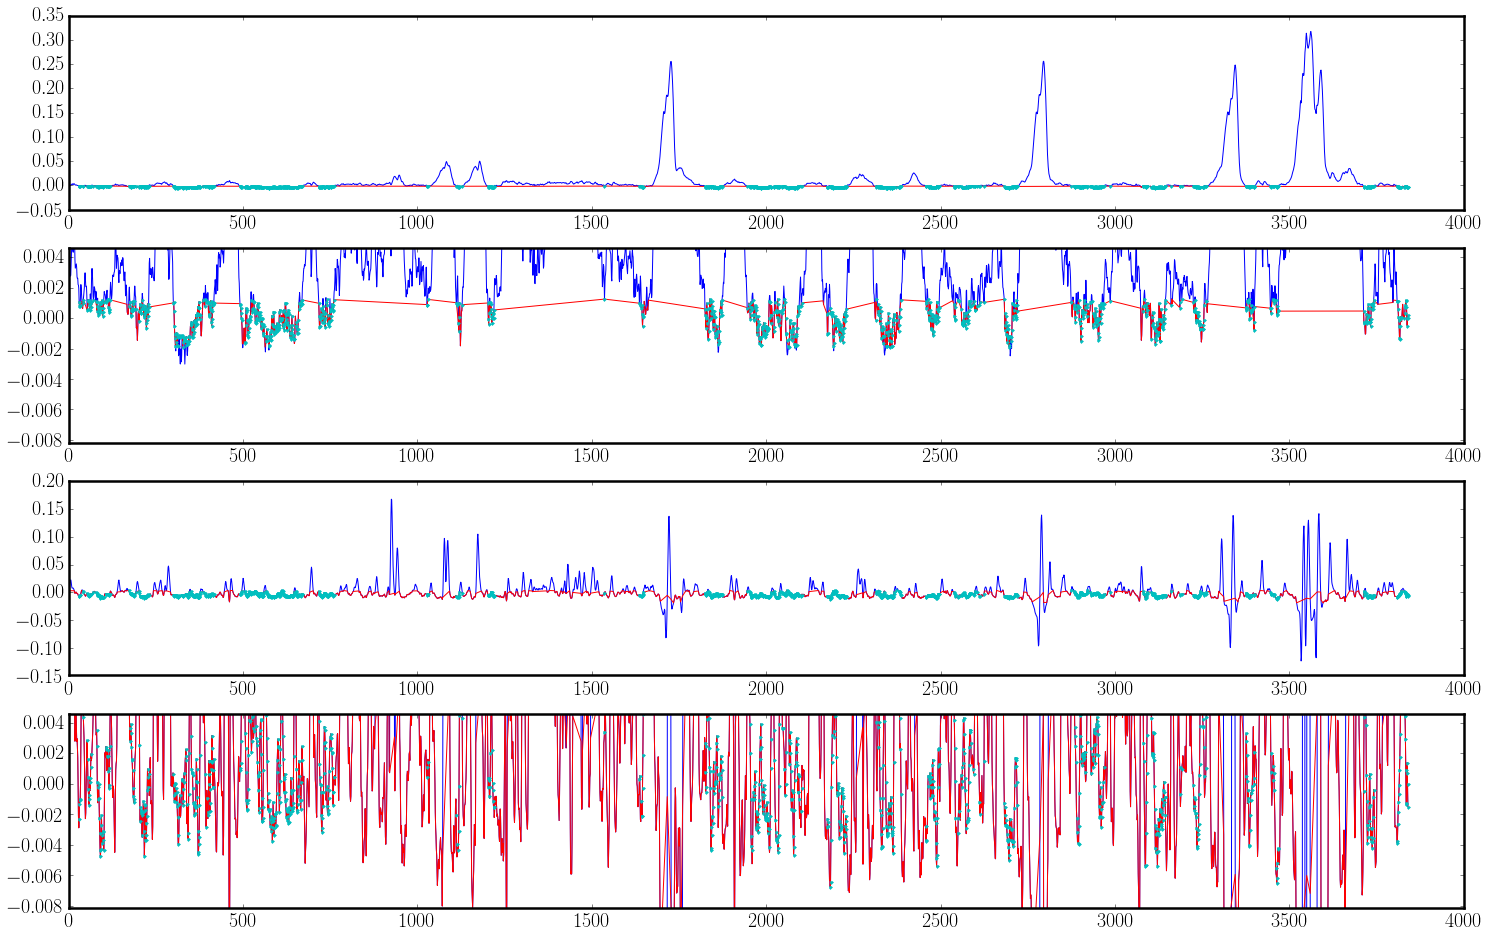

In [5]:
cont_all = ''
for myspw in spws:
    mycube = mydir+cubes_root+'_spw'+myspw+'.fits'
    cube = SpectralCube.read(mycube)
    sca = cube.subcube_from_ds9region(a_reg)
    scb = cube.subcube_from_ds9region(b_reg)
    ya = sca.mean(axis=(1,2))
    yb = scb.mean(axis=(1,2))
    # 
    # 090
    #cont_chan_1, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=2.,sm=2.,doplot=True,spec2=yb.value,sp2=2.,sm2=2.)
    # 
    # 240
    cont_chan_1, cont_chan_2, cont_chan_c = get_cont_ch(ya.value,sp=1.4,sm=2.5,doplot=True,spec2=yb.value,sp2=1.3,sm2=2.5)

    #cont_chan = get_cont_ch(ya,sp=1.35,sm=2.5,doplot=True)
    cont_all = cont_all+myspw+':'+cont_chan_c+','
    plt.savefig('fcontchan_'+cubes_root+'_spw'+myspw+'.pdf')

print(cont_all[0:-1])
